In [ ]:
#import packages
import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
#load images
image_path = "spade-terminal.png"
template_path = "template.png"

img = cv2.imread(image_path)
template = cv2.imread(template_path)
img = img.astype(np.uint8)
template = template.astype(np.uint8)

file_name = Path(image_path).name

In [469]:
def extract_cont(cont: np.ndarray, img: np.ndarray) -> np.ndarray:
    """Crop specified contour from larger image

    Args:
        cont (np.ndarray): individual contour of interest
        img (np.ndarray): greater image contour is located in

    Returns:
        np.ndarray: cropped image containing just the contour
    """
    
    temp_img = img.copy()
    
    #using rotated min area rect to create bonds for cropping
    (center, (w,h), theta) = cv2.minAreaRect(cont)
    w = int(w+10) #10 chosen as buffer
    h = int(h+10)
    
    #detecting if rotation would lead to portrait or landscape
    #if portrait (h>w) corrects
    if h > w:
        temp = w
        w = h
        h = temp
        theta = theta + 90
    
    #Transformation to correct rotation of image in reference to min rect
    R_M = cv2.getRotationMatrix2D(center, theta, 1.0)
    rot_img = cv2.warpAffine(temp_img, R_M, (temp_img.shape[1], temp_img.shape[0]))
    
    #find corner of rectangle
    cont_x = int(center[0] - w / 2)
    cont_y = int(center[1] - h / 2)
    
    crop = rot_img[cont_y:cont_y+h, cont_x:cont_x+w]
    
    return crop

In [470]:
def remove_background(img: np.ndarray) -> np.ndarray:
    """Clean up image background and remove artifacts

    Args:
        img (np.ndarray): cropped image of terminal

    Returns:
        np.ndarray: cropped image of terminal on clean white background
    """
    
    temp_img = img.copy()
    
    #find dim of image
    h = temp_img.shape[0]
    w = temp_img.shape[1]
    
    #init mask for blob as black photo
    mask = np.zeros((h,w), dtype=np.uint8)
    
    #init mask for background as white photo
    background = np.bitwise_not(np.zeros((h,w),dtype=np.uint8))
    
    #find largest blob in image, ideally this is the terminal
    cont, hier = cv2.findContours(temp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    blob = max(cont, key=cv2.contourArea)
    
    #draw blob in white on mask to make mask 
    cv2.drawContours(mask, [blob], 0, (255,255,255), cv2.FILLED)
    
    #create inverse of blob mask for the background
    inv_mask = np.bitwise_not(mask)
    
    #apply masks to blob and background
    masked_img = cv2.bitwise_and(temp_img, temp_img, mask=mask)
    masked_background = cv2.bitwise_and(background,background, mask=inv_mask)
    
    #join blob and background
    final = cv2.add(masked_img,masked_background)
    
    return final

In [ ]:
#binarization
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
thr,dst = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
thr_template,dst_template = cv2.threshold(gray_template, 60, 255, cv2.THRESH_BINARY)



# clean up
for i in range(1):
    dst = cv2.erode(dst, None)
    dst_template = cv2.erode(dst_template, None)
for i in range(1):
    dst = cv2.erode(dst, None)
    dst_template = cv2.dilate(dst_template, None)
    
cont, hier = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cont_template, hier_template = cv2.findContours(dst_template, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#final arrays of isolated terminals
cont_terminals = []
crop_terminals = []

for i in range(len(cont)):
    c = cont[i]
    h = hier[0,i]
    if h[2] == -1 and h[3] == 0:
        # no child and parent is image outer
        terminal = extract_cont(c,dst)
        terminal = remove_background(terminal)
        
        cont_terminals.append(c)
        crop_terminals.append(terminal)


In [ ]:
#final array of isolated bad terminals 
bad_terminals = []
cont_bad_terminals = []

for i in range(len(crop_terminals)):
    candidate = crop_terminals[i]
    candidate_cont = cont_terminals[i]
    
    d2 = cv2.matchShapes(candidate,dst_template,cv2.CONTOURS_MATCH_I2,0) #.2 for i2
    
    if d2 < .22:
        bad_terminals.append(candidate)
        cont_bad_terminals.append(candidate_cont)
    
img = cv2.drawContours(img, cont_bad_terminals, -1, (0,0,255),-1)    
    

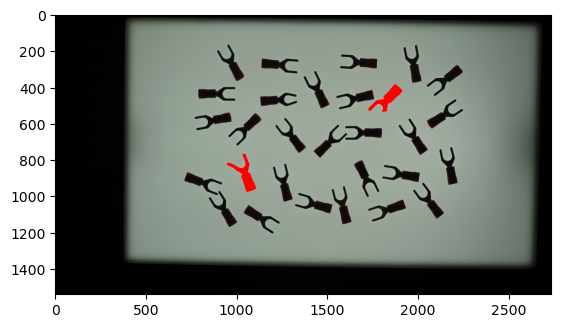

In [474]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

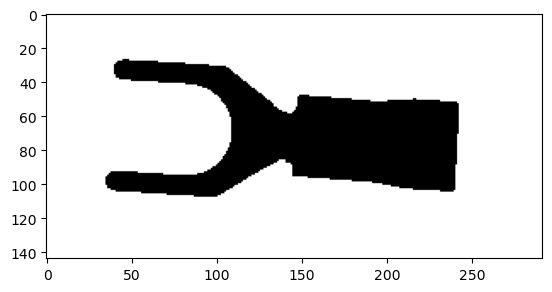

In [475]:

plt.imshow(cv2.cvtColor(dst_template, cv2.COLOR_BGR2RGB))
plt.show()